In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd

from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.network.heterogeneous_network import HeterogeneousNetwork

from moge.visualization.plot_data import matrix_heatmap

#  Import network from file

In [2]:
import pickle

# READ
with open('moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.pickle', 'rb') as file:
    network = pickle.load(file)
#     network.process_genes_info()

# READ Edgeslist
# network.import_edgelist_file(
#     file="moge/data/LMN_only_directed/lmn_l08_m08_l08__correlation_node_similarity.edgelist", 
#                              is_directed=True)

In [3]:
# READ edgelists
with open('moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_val.pickle', 'rb') as file:
    network_val = pickle.load(file)
#     network_val.process_genes_info()

# print("network_test", network_test.G.number_of_edges())
# print("network_val", network_val.G.number_of_edges())

In [4]:
import pickle
with open('moge/data/luad_data_multi_seq.pickle', 'rb') as file:
    luad_data = pickle.load(file)
    network.multi_omics_data = luad_data
    network.process_genes_info()

Genes info columns: ['Transcript sequence', 'Disease association', 'locus_type', 'GO Terms', 'Family']
Number of nodes without seq removed: -50
Total nodes (filtered): 32530


In [5]:
network.G.remove_edges_from([(u,v,d) for u,v,d in network.G.edges(data=True) if d["type"]=="u" or d["type"]=="u_n"])

# Data Visualization

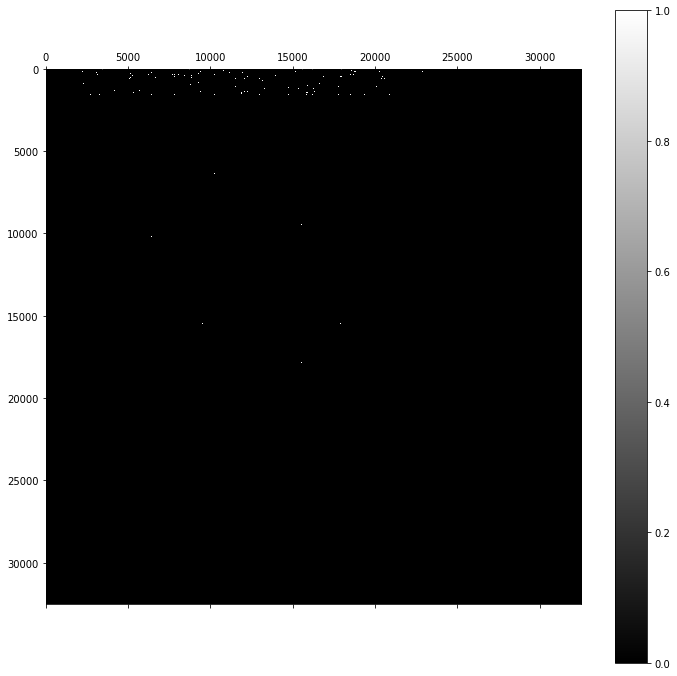

In [5]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list).todense())

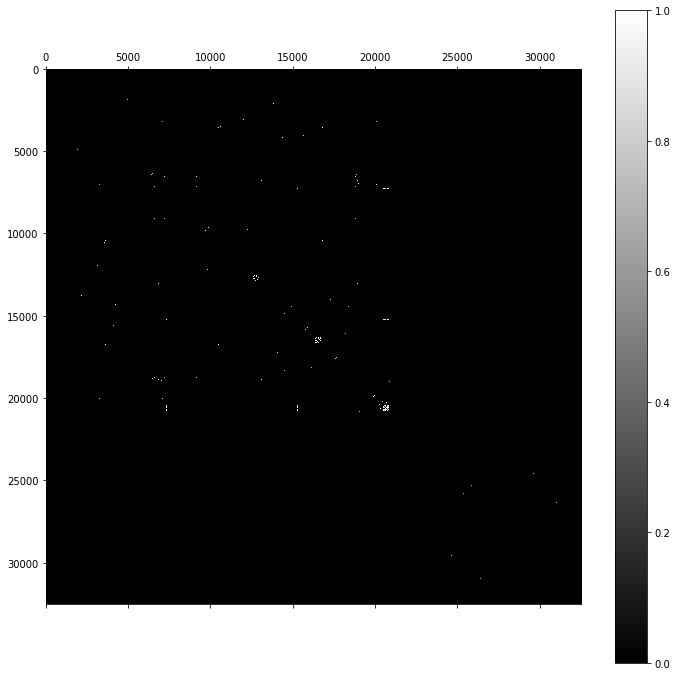

In [6]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.node_list).todense())

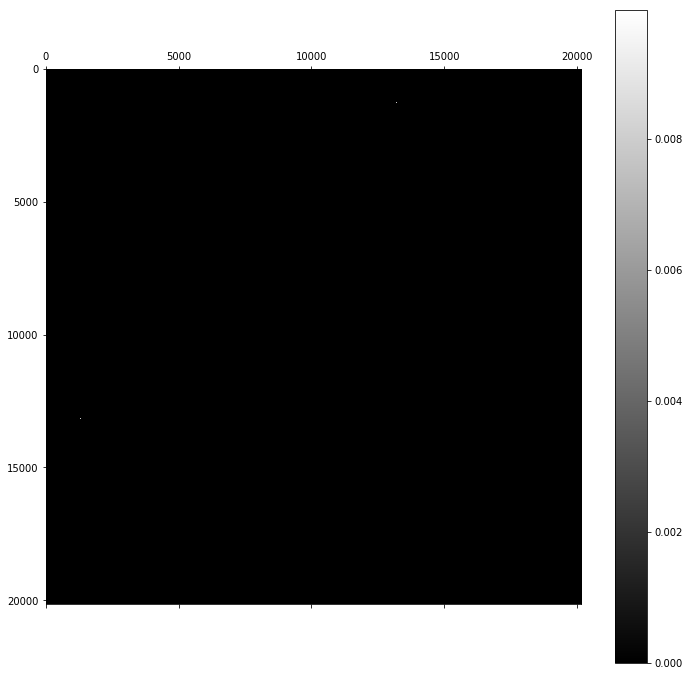

In [7]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.nodes["GE"]).todense())

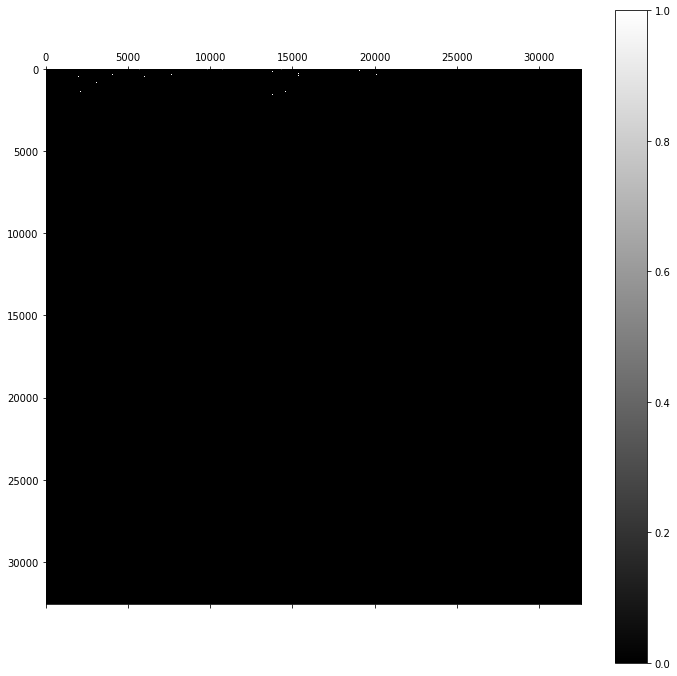

In [8]:
# The test data to recall
matrix_heatmap(network_val.get_adjacency_matrix(edge_types=["d"], node_list=network_val.node_list).todense())

# Train

In [6]:
from moge.embedding.siamese_graph_embedding import SiameseGraphEmbedding

siamese = SiameseGraphEmbedding(d=128, batch_size=2048, lr=0.001, epochs=20, negative_sampling_ratio=2.0,
                                 max_length=1400, truncating="random", verbose=True)

Using TensorFlow backend.


In [7]:
siamese.learn_embedding(network, network_val=network_val, multi_gpu=True, 
                        subsample=True, n_steps=300, validation_steps=50, compression_func="log",
                        seed=42)

Using SampledDataGenerator
Ed_count: 351896 , Eu_count: 0 , En_count: 0


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:214: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  ", try using != instead.", SparseEfficiencyWarning)


Ens_count: 703792
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5}
# of nodes to sample from (non-zero degree): 10623
Ed_count: 69148 , Eu_count: 0 , En_count: 0
Ens_count: 138296
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5}
Embedding Tensor("embedding_1/embedding_lookup/Identity:0", shape=(?, ?, 5), dtype=float32, device=/device:CPU:0)
conv2D Tensor("lambda_2/Squeeze:0", shape=(?, ?, 192), dtype=float32, device=/device:CPU:0)
max pooling_1 Tensor("max_pooling1d_1/Squeeze:0", shape=(?, ?, 192), dtype=float32, device=/device:CPU:0)
conv1d_2 Tensor("conv1d_1/Relu:0", shape=(?, ?, 320), dtype=float32, device=/device:CPU:0)
max pooling_2 Tensor("max_pooling1d_2/Squeeze:0", shape=(?, ?, 320), dtype=float32, device=/device:CPU:0)
brnn Tensor("bidirectional_1/concat_2:0", shape=(?, 640), dtype=float32, device=/device:CPU:0)
embedding Tensor("dense_3/BiasAdd:0", shape=(?, 128), dtype=float32, device=/device:CPU:0)
Instructions for updating:
Please switch to tf.metrics.auc. 

# Visualize Embeddings

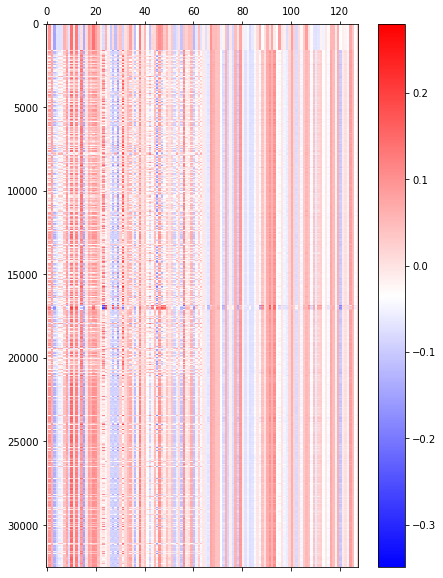

In [8]:
matrix_heatmap(siamese.get_embedding(), cmap="bwr", aspect='auto', figsize=(7,10))

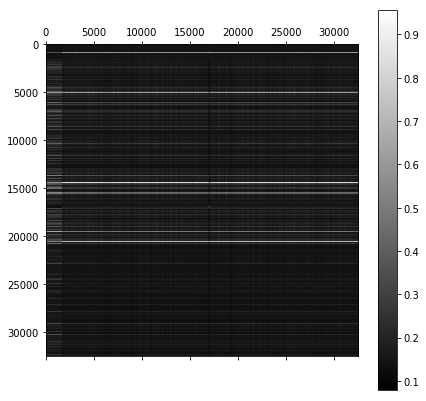

In [9]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="d", node_l=network.node_list),figsize=(7,7))

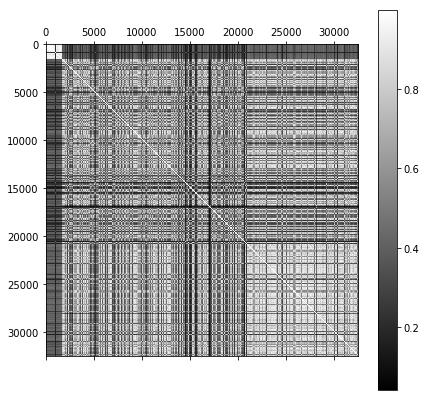

In [10]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="u", node_l=network_val.node_list), figsize=(7,7))

# Plot measures on training and testing

In [ ]:
import matplotlib.pyplot as plt
history = siamese.history
print(history.history.keys())
plt.figure(dpi=300)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
# plt.title('Link prediction performance')
plt.ylabel('AUC ROC score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# Save Model & Embedding

In [8]:
siamese.lstm_network.save("moge/data/LMN_only_directed/lmn_edges20/lstm_128_randtrunc_multi_edge20_interactions_e20.h5")

In [9]:
siamese.truncating = "post"
siamese.save_embeddings("moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.siamese_multi_interactions.emb", 
                        variable_length=False, recompute=True, minlen=100)

In [ ]:
lstm_network.summary()

# Import different models

In [10]:
from moge.embedding.static_graph_embedding import ImportedGraphEmbedding

node2vec_emb = ImportedGraphEmbedding(d=128, method_name="node2vec")
node2vec_emb.import_embedding("moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.node2vec.emb", 
                          node_list=network.node_list)

line_emb = ImportedGraphEmbedding(d=128, method_name="LINE")
line_emb.import_embedding("moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.line.emb", 
                          node_list=network.node_list)

hope_emb = ImportedGraphEmbedding(d=128, method_name="HOPE")
hope_emb.import_embedding("moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.hope.emb", 
                          node_list=network.node_list)

sdne_emb = ImportedGraphEmbedding(d=128, method_name="SDNE")
sdne_emb.import_embedding("moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.sdne.emb", 
                          node_list=network.node_list)


rna2rna_emb = ImportedGraphEmbedding(d=128, method_name="rna2rna")
rna2rna_emb.import_embedding("moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.siamese_multi_maxlen.emb", 
                         node_list=network.node_list)
print()

node2vec imported (17905, 128)
LINE imported (17905, 128)
HOPE imported (17905, 128)
SDNE imported (17905, 128)
rna2rna imported (32530, 128)



# Prepare True label

In [ ]:
from moge.network.data_generator import DataGenerator

negative_sampling_ratio = 2.0
generator_Ed = DataGenerator(network=network_val, 
                             negative_sampling_ratio=negative_sampling_ratio,
                             batch_size=siamese.batch_size,
                             maxlen=1400,
                             truncating="post",
                             shuffle=True, seed=0)
generator_Ed.on_epoch_end()


Ed_count: 69148 , Eu_count: 0 , En_count: 0
Ens_count: 138296
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5}


In [ ]:
X, y_true = generator_Ed.make_dataset()
y_true.shape
# y_true = y_true.astype(int)
# y_true = (y_true > 0).astype(int)

(206848, 1)

In [ ]:
y_pred_dict = {}
y_pred_dict["LINE"] = line_emb.predict(X)
y_pred_dict["HOPE"] = hope_emb.predict(X)
y_pred_dict["SDNE"] = sdne_emb.predict(X)
y_pred_dict["node2vec"] = node2vec_emb.predict(X)
y_pred_dict["rna2rna"] = rna2rna_emb.predict(X)
y_pred_dict["siamese"] = siamese.predict_generator(generator_Ed)

In [ ]:
color_dict = {}
color_dict["LINE"] = "b"
color_dict["HOPE"] = "b"
color_dict["SDNE"] = "y"
color_dict["node2vec"] = "g"
color_dict["rna2rna"] = "r"
color_dict["siamese"] = "r"

ls_dict = {}
ls_dict["LINE"] = ":"
ls_dict["HOPE"] = "-"
ls_dict["SDNE"] = "--"
ls_dict["node2vec"] = "--"
ls_dict["rna2rna"] = "-"
ls_dict["siamese"] = ":"

# Plot Precision-Recall Curve

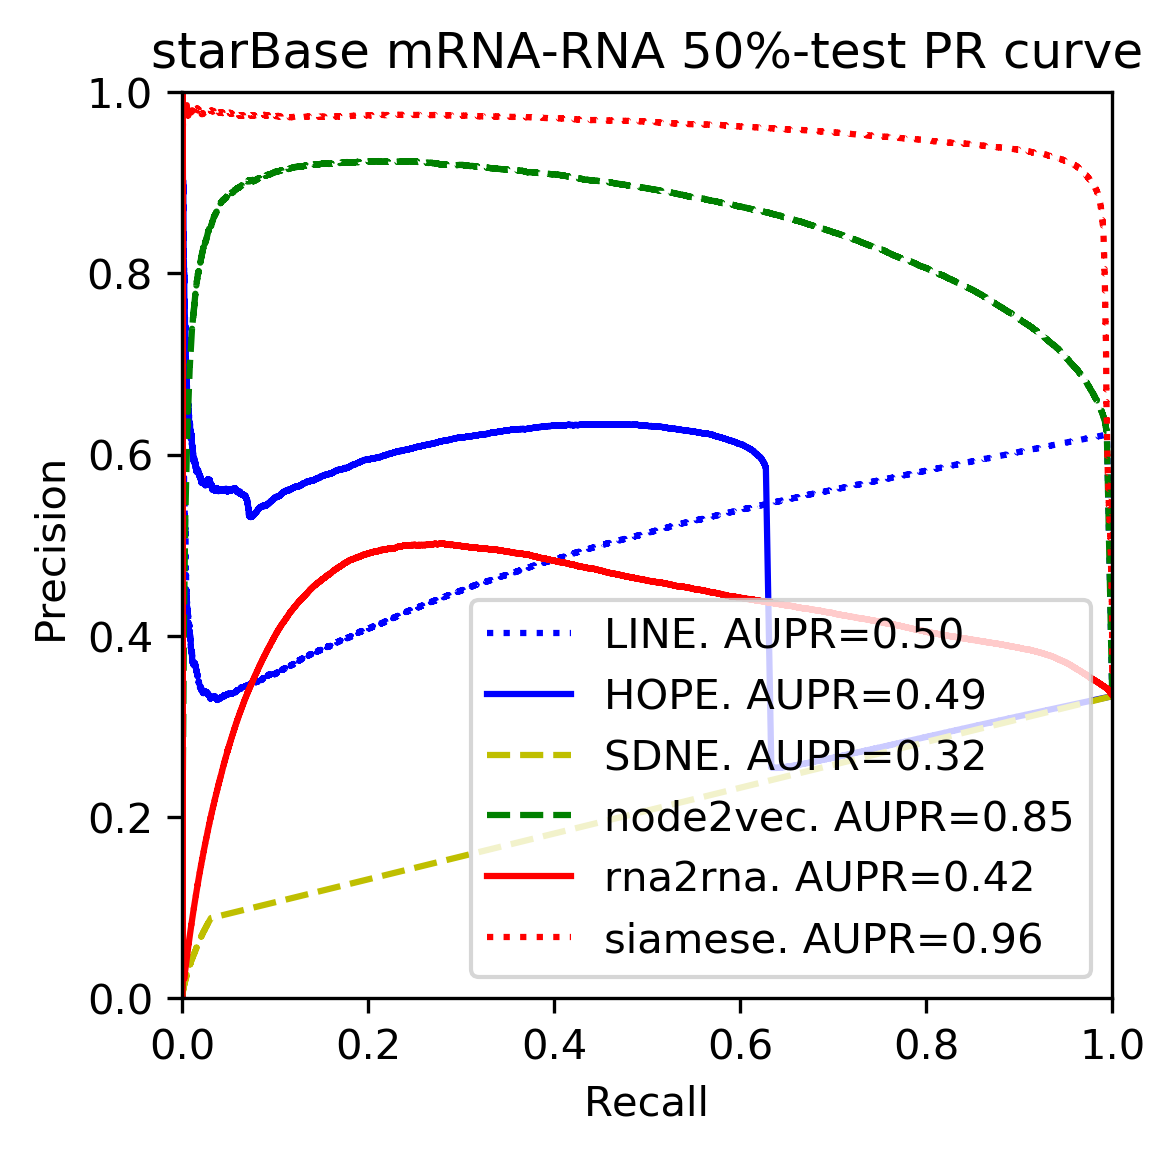

In [ ]:
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score ,precision_recall_curve

fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(111)

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

for method in y_pred_dict.keys():
    y_prob_pred = y_pred_dict[method]
    average_precision = average_precision_score(y_true=y_true, y_score=y_prob_pred)
    precision, recall, _ = precision_recall_curve(y_true=y_true, probas_pred=y_prob_pred, pos_label=1)

    ax.plot(recall, precision, color=color_dict[method], ls=ls_dict[method],
             label=method+'. AUPR={0:0.2f}'.format(average_precision))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.00])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower right")
plt.title('starBase mRNA-RNA 50%-test PR curve')
plt.show()

In [ ]:
# fig.savefig("moge/data/LMN_only_directed/results/starBase_mRNA-RNA_50_pr.pdf", bbox_inches='tight')

# AUC Rate

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>